In [90]:
import torch
from torch import Tensor
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F

In [91]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import itertools

In [145]:
# a_ij * p_ij * w_i. w_i weight given by 1/degree(node_i) 
def loss_fn(output, adjacency_mat, payoff_mat):
    payoff_sum = torch.tensor([0.0])
    num_nodes = output.size()[0]
    id_mat = torch.eye(num_nodes)
    nodes_degree = sum(adjacency_mat)
    for i in range(num_nodes):
        for j in range(num_nodes):
            coeff = torch.matmul(torch.matmul(adjacency_mat,id_mat[i,:]),id_mat[j,:])
            payoff = torch.matmul(torch.matmul(payoff_mat,output[i,:]),output[j,:])
            payoff_sum += coeff * payoff * (1/nodes_degree[i])
    neg_payoff = - payoff_sum
    return neg_payoff

In [146]:
def create_graph_nodes(num_nodes, num_feats, seed):
    np.random.seed(seed)
    # Create nodes and corresponding features 

    x_list = []
    for n in range(num_nodes):
        x_unnorm = np.random.uniform(size=num_feats)
        x_norm = x_unnorm/sum(x_unnorm)
        x_list.append(x_norm)
    x_tensor = torch.tensor(x_list, dtype=torch.float)
    return x_tensor

In [147]:
def create_edges(kind, num_nodes, num_feats, seed, self_intersection):
    np.random.seed(seed)
    # Create symmetric edges with no self-interaction on nodes
    edges_list = []
    
    if kind == 'n_strat_uniform_prob_link':
        prob_link = GRAPHS_EX[kind]['prob_link']
        for i in itertools.combinations(range(num_nodes),2):
            if np.random.binomial(n=1, p=prob_link) == 1:
                edges_list.append(i)
                edges_list.append(i[::-1])
    elif kind == '3_strat_2_graphs_1_el_in_middle':
        prob_link = GRAPHS_EX[kind]['prob_link']
        end1 = (num_nodes//2)
        end2 = num_nodes - 1
        for i in itertools.combinations(range(end1),2):
            if np.random.binomial(n=1, p=prob_link) == 1:
                edges_list.append(i)
                edges_list.append(i[::-1])
        for i in itertools.combinations(range(end1,end2),2):
            if np.random.binomial(n=1, p=prob_link) == 1:
                edges_list.append(i)
                edges_list.append(i[::-1])
        edges_list.append((0,num_nodes-1))
        edges_list.append((num_nodes-1,0))
        edges_list.append((num_nodes-2,num_nodes-1))
        edges_list.append((num_nodes-1,num_nodes-2))
    
    if self_intersection:
        for i in range(num_nodes):
            edges_list.append((i,i))
        
        
    return edges_list

In [176]:
GRAPHS_EX = {'n_strat_uniform_prob_link':{'prob_link':0.5}, '3_strat_2_graphs_1_el_in_middle':{'prob_link':1.0}}

In [206]:
num_feats = 2
num_nodes = 9

In [207]:
# Create nodes and their features
X = create_graph_nodes(num_nodes, num_feats, seed=7)

In [208]:
X[:5,] # num_nodes x num_features

tensor([[0.0891, 0.9109],
        [0.3773, 0.6227],
        [0.6449, 0.3551],
        [0.8743, 0.1257],
        [0.3494, 0.6506]])

In [209]:
# Create edges
edges_list = create_edges(kind='3_strat_2_graphs_1_el_in_middle', num_nodes=num_nodes, num_feats=num_feats, seed=7, self_intersection=False)
edges = torch.tensor(edges_list, dtype=int).T

num nodes: 9
num edges: 28


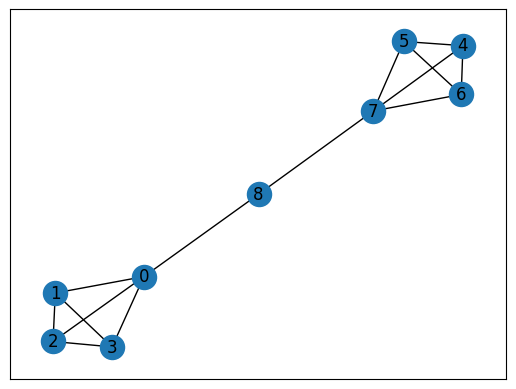

In [181]:
# Visualize graph
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges_list)
nx.draw_networkx(G)

print(f"num nodes: {num_nodes}")
print(f"num edges: {len(edges_list)}")

In [210]:
def create_payoff_matrix(kind):
    # Define payoff matrix P(node1,node2) = node1^T*P*node2  to define fitness when two nodes interact
    
    if kind == 'ex1':
        p12 = 1.0; p13 = 0.5; p23 = 0.5; p11 = 1.0; p22 = 1.0; p33 = 10.0
        P = torch.tensor([[p11, p12 , p13],[p12, p22 , p23],[p13, p23 , p33]])
        
    if kind == 'ex2':
        p12 = -10.0; p13 = 0.0; p23 = 0.0; p11 = 10.0; p22 = 10.0; p33 = 5.0
        P = torch.tensor([[p11, p12 , p13],[p12, p22 , p23],[p13, p23 , p33]])
    
    if kind == 'ex3':
        torch.manual_seed(0)
        P = torch.rand(num_feats,num_feats, dtype=torch.float)
        # P = (P + P.T)/2 # make it symmetric
    
    if kind == 'ex4':
        # rock-scissors-paper. # not symmetric
        p11 = 0.0; p12 = 1.0; p13 = -1.0; p23 = 1.0; p22 = 0.0; p33 = 0.0
        p21 = -p12; p31 = -p13; p23 = -p32;
        P = torch.tensor([[p11, p12 , p13],[p21, p22 , p23],[p31, p32 , p33]])
    
    if kind == 'ex5':
        # hawk-dove. if v> d all hawk, otherwise v
        v = 2.0
        d = 1.0
        p11 = (v-d)/2; p12 = v; p21 =0; p22 = d/2;
        P = torch.tensor([[p11, p12],[p21, p22]])
    
    
    return P

In [211]:
# Create adjacency matrix corresponding to edges list
A = np.zeros((num_nodes,num_nodes))
for el in edges_list:
    A[el[0],el[1]] = 1
A = torch.tensor(A, dtype=torch.float)

In [212]:
# Create payoff matrix
P = create_payoff_matrix(kind='ex5')

In [213]:
P

tensor([[0.5000, 2.0000],
        [0.0000, 0.5000]])

In [198]:
# Loss l. Graph G, P payoff. nodes n1, n2
# l(G) = - sum_{edges}(n1^T * P * n2)

In [231]:
X_dove = torch.stack((torch.ones(num_nodes),torch.zeros(num_nodes)))


tensor([0.0891, 0.3773, 0.6449, 0.8743, 0.3494, 0.4580, 0.8525, 0.2406, 0.3206])

In [ ]:
X_dove

In [214]:
loss_fn(output=X.float(), adjacency_mat=A.float(), payoff_mat =P.float())

tensor([-6.5346])

In [215]:
# Convolution update


In [216]:
# Architecture: num layers

class GCN(torch.nn.Module):
    def __init__(self, num_features, hid1_in, hid2_in):
        super().__init__()
        # todo: add more layers
        # todo: simplify gcn layers
        self.conv1 = GCNConv(num_features, hid1_in)
        self.conv2 = GCNConv(hid1_in, hid2_in)
        self.conv3 = GCNConv(hid2_in, num_features)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        # x: Node feature matrix of shape [num_nodes, num_features]
        # edge_index: Graph connectivity matrix of shape [2, num_edges]
        x = self.conv1(x, edge_index).relu()
        #x = F.softmax(x, dim=1)
        x = self.conv2(x, edge_index)
        #x = F.softmax(x, dim=1)
        x = self.conv3(x, edge_index)
        x = F.softmax(x, dim=1)
        return x

In [217]:
edges.size()

torch.Size([2, 28])

In [227]:
preds = []
losses = []
num_epochs = 2000
hid1_in = 10
hid2_in = 10

model = GCN(num_features = num_feats, hid1_in=hid1_in, hid2_in=hid2_in)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(num_epochs):
    pred = model(X, edges)
    loss = loss_fn(output=pred, adjacency_mat=A, payoff_mat=P)
    #loss = F.cross_entropy(pred[data.train_mask], data.y[data.train_mask])

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    preds.append(pred)
    losses.append(loss.item())

Text(0, 0.5, 'loss')

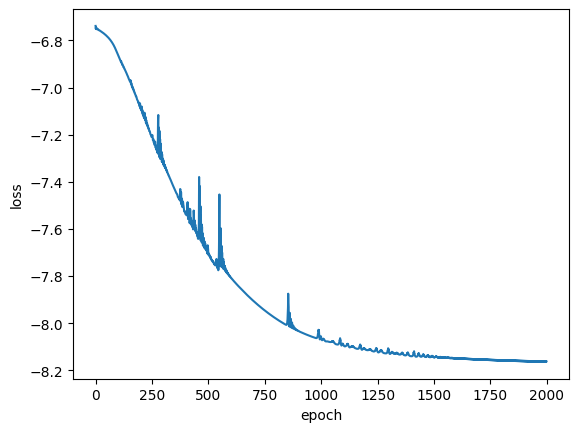

In [228]:
fig, ax = plt.subplots(1,1)
ax.plot(range(num_epochs),losses)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

In [229]:
pred

tensor([[0.9926, 0.0074],
        [0.1877, 0.8123],
        [0.1877, 0.8123],
        [0.1877, 0.8123],
        [0.1932, 0.8068],
        [0.1932, 0.8068],
        [0.1932, 0.8068],
        [0.9928, 0.0072],
        [0.0040, 0.9960]], grad_fn=<SoftmaxBackward0>)

In [28]:
stop

NameError: name 'stop' is not defined

In [ ]:
# Interpretation as multiple strategy of single individual or single strategies for multiple individuals

In [ ]:
stop

In [ ]:
# Move tensor to GPU if available
print(torch.cuda.is_available())
if torch.cuda.is_available():
    tensor = tensor.to("cuda")

In [ ]:
"""np.random.seed(7)
# Create payoff matrix to define loss function
A0 = np.zeros(shape=(num_nodes, num_nodes))
prob_link = 0.5
for i in range(num_nodes):
    A0[i,i:] = np.random.binomial(n=1, p=prob_link, size=num_nodes-i)    
A = A0 + A0.T
for i in range(num_nodes):
    A[i,i] = 0"""